This script quantifies non-additive effects as in PMID 25897392.

In [1]:
import pandas, numpy

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
expression_file = '/home/adrian/projects/nautholsvik/results/tpm/DESeq2_TPM_values.tsv'
significance_dir = '/home/adrian/projects/nautholsvik/results/DEGs_DESeq2/'
annotation_file = '/home/adrian/projects/nautholsvik/results/annotation/annotation.csv'

In [4]:
genotypes = ['siCTRL', 'siMITF']
treatments = ['wo_IFN', 'with_IFN']

# 1. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(40221, 1)


,ext_gene
ens_gene,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1


# 2. read and manipulate expression data

In [6]:
expression_with_replicates = pandas.read_csv(expression_file, sep='\t', index_col=0)

In [7]:
plotting_df = pandas.DataFrame()
replicate_labels = expression_with_replicates.columns

for genotype in genotypes:
    for treatment in treatments:
        new_label = genotype + '_' + treatment + '_tpm'
        sub = [label for label in replicate_labels if genotype in label and treatment in label]
        df = expression_with_replicates[sub]
        plotting_df[new_label] = df.median(axis=1)

In [8]:
plotting_df['average_expression_tpm'] = plotting_df.mean(axis=1)
plotting_df['max_expression_tpm'] = plotting_df.max(axis=1)

plotting_df['geneID'] = annotation['ext_gene']
plotting_df.loc[plotting_df['geneID'].isnull(), 'geneID'] = plotting_df.index[plotting_df['geneID'].isnull()]

print(plotting_df.shape)
plotting_df.head()

(40173, 7)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112


# 3. add fold-changes of each independent effect

In [9]:
plotting_df['A1A0_log2fc'] = numpy.log2(plotting_df['siCTRL_with_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)
plotting_df['B0A0_log2fc'] = numpy.log2(plotting_df['siMITF_wo_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,-0.119387,-0.049295
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD,0.000000,0.000000
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,-0.049439,0.100731
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,0.515283,0.468401
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,-0.359831,-0.344281


# 4. read fold changes and P values from DESeq2

In [10]:
# read signifcances
df = pandas.read_csv(significance_dir+'A0_A1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_A1A0'] = df['padj']

df = pandas.read_csv(significance_dir+'A0_B0_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B0A0'] = df['padj']

df = pandas.read_csv(significance_dir+'interaction.tsv', sep='\t', index_col=0)
plotting_df['P_interaction'] = df['padj']

# 5. remove element whose top expression is below 2 TPM

In [11]:
plotting_df.fillna(1, inplace=True)

In [12]:
# remove low-expression genes: less than two tpm
print(plotting_df.shape)
plotting_df.drop(plotting_df[plotting_df['max_expression_tpm'] < 2].index, inplace=True)
print(plotting_df.shape)

(40173, 12)
(12742, 12)


In [13]:
plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16


In [14]:
plotting_df.loc['ENSG00000284610', ]

siCTRL_wo_IFN_tpm                5.648556
siCTRL_with_IFN_tpm              3.222984
siMITF_wo_IFN_tpm                1.713617
siMITF_with_IFN_tpm              2.304635
average_expression_tpm           3.222448
max_expression_tpm               5.648556
geneID                    ENSG00000284610
A1A0_log2fc                     -0.654778
B0A0_log2fc                     -1.292824
P_A1A0                           0.054976
P_B0A0                                0.0
P_interaction                    0.030959
Name: ENSG00000284610, dtype: object

In [15]:
# these numbers is to see the effect of removing low-expressed genes, it is not represtantive of the final set of genes, specially for the interaction
# originally, at the significance level we had A1A0: 4,414; B0A0: 9,116 and interaction: 700
print(sum(plotting_df['P_A1A0'] < 0.1))
print(sum(plotting_df['P_B0A0'] < 0.1))
print(sum(plotting_df['P_interaction'] < 0.1))

3929
7633
631


In [16]:
# check if MITF is A0 to B0 transition
print('ENSG00000187098' in plotting_df[plotting_df['P_B0A0'] < 0.1].index)

# check if PD-L1 is a gene with significant interaction
print('ENSG00000120217' in plotting_df[plotting_df['P_interaction'] < 0.1].index)

True
True


# 6. add a column of the expected expression given both factors

In [17]:
# add expected expression
deltaA = plotting_df['siCTRL_with_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
deltaB = plotting_df['siMITF_wo_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
expected = plotting_df['siCTRL_wo_IFN_tpm'] + deltaA + deltaB
plotting_df['expected'] = expected 
plotting_df.loc[plotting_df['expected'] < 0,'expected'] = 0 # avoid predicting negative expression

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00,21.941919
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00,154.617808
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00,12.477084
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00,23.692946
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16,2.244778


# 7. determine non-linear effects at fold-change level

In [18]:
# add log2FC observed / expected expression
non_additive = numpy.log2(plotting_df['siMITF_with_IFN_tpm']+1) - numpy.log2(plotting_df['expected']+1)
plotting_df['log2FC_observed_expected'] = non_additive

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00,21.941919,0.102948
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00,154.617808,0.018931
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00,12.477084,-0.070694
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00,23.692946,-0.085337
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16,2.244778,1.684238


# 8. learn type of non-additive effect

In [19]:
plotting_df['interaction_type'] = 'not avail.'

for ensembl, row in plotting_df.iterrows():
        
    CT = plotting_df.loc[ensembl, 'siCTRL_wo_IFN_tpm']
    A = plotting_df.loc[ensembl, 'siCTRL_with_IFN_tpm']
    B = plotting_df.loc[ensembl, 'siMITF_wo_IFN_tpm']
    obs = plotting_df.loc[ensembl, 'siMITF_with_IFN_tpm']
    AB = plotting_df.loc[ensembl, 'expected']
    
    ### case (i) in Figure 2 from PMID 25897392
    if A < CT and B < CT:
        if obs > CT:
            relationship = '+S'
        elif CT > obs > AB:
            relationship = '-A'
        elif obs < AB:
            relationship = '-S'
        elif obs == AB:
            relationship = 'additive'
        else:
            print(CT, A, B, AB, obs)            
            raise ValueError('case (i) not handled')
            
    ### case (ii) in Figure 2 from PMID 25897392
    elif (A > CT and B < CT) or (A < CT and B > CT):
        if obs > numpy.max([A, B]):
            relationship = '+S'
        elif numpy.max([A, B]) > obs > AB:
            relationship = '-A'
        elif AB > obs >= numpy.min([A, B]): # the equal here is for full +A
            relationship = '+A'
        elif obs < numpy.min([A, B]):
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (ii) not handled')
    
    ### case (iii) in Figure 2 from PMID 25897392
    elif A >= CT and B >= CT:
        if obs > AB:
            relationship = '+S'
        elif AB > obs >= CT: # the equal here is bc it goes back to zero, full +A
            relationship = '+A'
        elif obs < CT:
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (iii) not handled')
    else:
        print(CT, A, B, AB, obs)
        raise ValueError('unknown case not handled')
        
    # assignment
    plotting_df.loc[ensembl, 'interaction_type'] = relationship

# 8. exploratory subsetting

In [20]:
# expecting 222 passing log2 filter

non_additive_df = plotting_df[numpy.abs(plotting_df['log2FC_observed_expected']) > 1]
print(non_additive_df.shape)
non_additive_df.head()

(222, 15)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,1.352847,-0.273603,4.909581e-46,3.251351e-03,3.700648e-16,2.244778,1.684238,+S
ENSG00000004487,121.353473,217.621951,91.539242,88.257174,129.692960,217.621951,KDM1A,0.837383,-0.402918,1.333847e-50,1.439674e-22,3.064888e-27,187.807721,-1.080878,-S
ENSG00000004777,0.632326,0.740612,2.840188,0.700037,1.228291,2.840188,ARHGAP33,0.092665,1.234247,1.000000e+00,2.382447e-18,1.219202e-02,2.948473,-1.215729,+A
ENSG00000005981,73.125427,54.287924,23.883388,23.477727,43.693616,73.125427,ASB4,-0.423004,-1.574786,3.767529e-12,1.156243e-192,1.564934e-04,5.045885,2.017444,-A
ENSG00000006451,83.490302,198.225113,64.786113,82.954481,107.364002,198.225113,RALA,1.237542,-0.361003,4.035045e-80,2.210655e-19,5.048511e-09,179.520924,-1.104487,+A


In [21]:
# expecting 66 passing both significance and log2 filters

non_additive_and_significant_df = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]

# check if PD-L1 is a gene with significant interaction (ENSG00000120217)
print('ENSG00000120217' in non_additive_and_significant_df.index)

print(non_additive_and_significant_df.shape)
non_additive_and_significant_df.head()

False
(66, 15)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,1.352847,-0.273603,4.909581e-46,3.251351e-03,3.700648e-16,2.244778,1.684238,+S
ENSG00000004487,121.353473,217.621951,91.539242,88.257174,129.692960,217.621951,KDM1A,0.837383,-0.402918,1.333847e-50,1.439674e-22,3.064888e-27,187.807721,-1.080878,-S
ENSG00000004777,0.632326,0.740612,2.840188,0.700037,1.228291,2.840188,ARHGAP33,0.092665,1.234247,1.000000e+00,2.382447e-18,1.219202e-02,2.948473,-1.215729,+A
ENSG00000005981,73.125427,54.287924,23.883388,23.477727,43.693616,73.125427,ASB4,-0.423004,-1.574786,3.767529e-12,1.156243e-192,1.564934e-04,5.045885,2.017444,-A
ENSG00000006451,83.490302,198.225113,64.786113,82.954481,107.364002,198.225113,RALA,1.237542,-0.361003,4.035045e-80,2.210655e-19,5.048511e-09,179.520924,-1.104487,+A


In [22]:
# expecting 86 cases of more than 150% change

# border-line cases, 13 cases for 0.9 up to 1.
# if we we a threshold of 150%, then we have 86, including PD-L1
border_line = plotting_df[(plotting_df['P_interaction'] < 0.05) & (numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (numpy.abs(plotting_df['log2FC_observed_expected']) < 1)]
print('CD274' in border_line['geneID'].values)
print(border_line.shape)
border_line

True
(86, 15)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000001617,1.884419,10.023886,0.858288,17.860497,7.656773,17.860497,SEMA3F,1.934280,-0.634306,2.693530e-60,1.073405e-08,6.015352e-14,8.997756,0.915691,+S
ENSG00000004799,297.741446,147.271278,268.412358,213.451657,231.719185,297.741446,PDK4,-1.010658,-0.149081,3.572457e-46,2.640394e-09,9.601362e-09,117.942191,0.850392,-A
ENSG00000004846,9.545795,6.299187,0.393679,0.575647,4.203577,9.545795,ABCB5,-0.530860,-2.919698,2.351728e-06,1.886591e-123,3.265272e-04,0.000000,0.655944,-A
ENSG00000026950,6.429726,12.034970,8.110338,24.814643,12.847419,24.814643,BTN3A1,0.811006,0.294196,4.195168e-06,1.000000e+00,4.696302e-03,13.715582,0.810845,+S
ENSG00000065371,15.112306,14.020806,5.317740,8.408569,10.714855,15.112306,ROPN1,-0.101201,-1.350682,1.000000e+00,1.683780e-26,7.807860e-03,4.226240,0.848202,-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000206452,13.809269,111.279021,14.478451,189.603890,82.292658,189.603890,ENSG00000206452,2.922516,0.063761,1.214954e-282,1.000000e+00,3.263938e-08,111.948203,0.754916,+S
ENSG00000215817,7.862969,6.552685,2.336237,2.513366,4.816314,7.862969,ZC3H11B,-0.230800,-1.409568,2.049406e-04,1.567361e-116,1.848965e-04,1.025953,0.794253,-A
ENSG00000227051,1.869758,3.265980,1.420025,1.179776,1.933885,3.265980,C14orf132,0.571948,-0.245908,7.429390e-14,1.839918e-04,2.370069e-02,2.816246,-0.807974,-S
ENSG00000273686,690.196169,2806.907857,828.823798,4747.825321,2268.438286,4747.825321,B2M,2.022328,0.263710,5.545732e-128,1.000000e+00,5.572132e-05,2945.535486,0.688551,+S


In [23]:
border_line.loc['ENSG00000120217', ] # CD274

siCTRL_wo_IFN_tpm             1.80042
siCTRL_with_IFN_tpm          9.498778
siMITF_wo_IFN_tpm            0.618063
siMITF_with_IFN_tpm         14.259616
average_expression_tpm       6.544219
max_expression_tpm          14.259616
geneID                          CD274
A1A0_log2fc                  1.906506
B0A0_log2fc                 -0.791376
P_A1A0                            0.0
P_B0A0                       0.000008
P_interaction                     0.0
expected                     8.316421
log2FC_observed_expected     0.711871
interaction_type                   +S
Name: ENSG00000120217, dtype: object

# 9. actual subsetting

In [24]:
# plotting set A (n = 66): log2(2) + P
# plotting set B (n = 222): log2(2)
# plotting set C (n = 152): log2(1.5) + P
# plotting set D (n = 619): log2(1.5)

plotting_setA = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setA.shape)

plotting_setB = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1)]
print(plotting_setB.shape)

plotting_setC = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setC.shape)

plotting_setD = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5))]
print(plotting_setD.shape)

(66, 15)
(222, 15)
(152, 15)
(619, 15)


# 10. plot

## 10.1. set A

In [37]:
15+20+23+8

66

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 488.6275888051749
-4.345253020438813 5.867488277016092
number of genes in the figure: 15


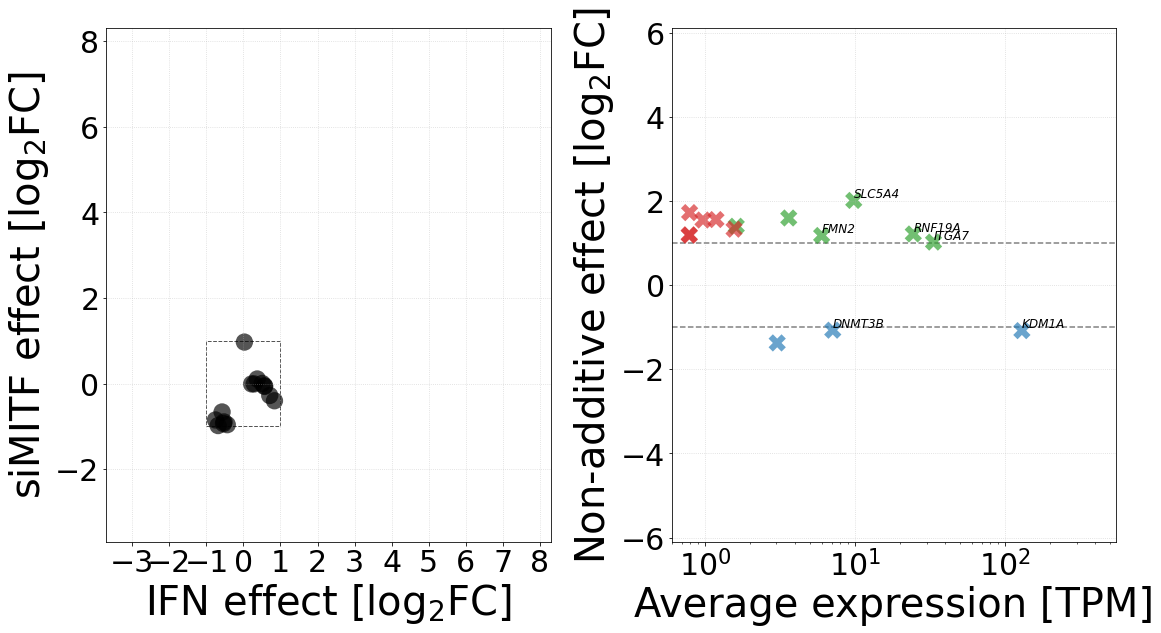

In [27]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9))

x = plotting_setA['A1A0_log2fc'].values
y = plotting_setA['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setA['average_expression_tpm'].values
y = plotting_setA['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

#
# left panel
#
for ensembl, row in plotting_setA.iterrows():
    x = plotting_setA.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setA.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) < 1 and numpy.abs(y) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setA.loc[ensembl, 'average_expression_tpm']
        y = plotting_setA.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setA.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setA.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            the_label = plotting_setA.loc[ensembl, 'geneID']
            right_panel.text(x, y, the_label, horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
left_panel.set_xlim([-3.7, 8.3])
left_panel.set_ylim([-3.7, 8.3])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xlim([0.6, 550])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')
    
matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 488.6275888051749
-4.345253020438813 5.867488277016092
number of genes in the figure: 20


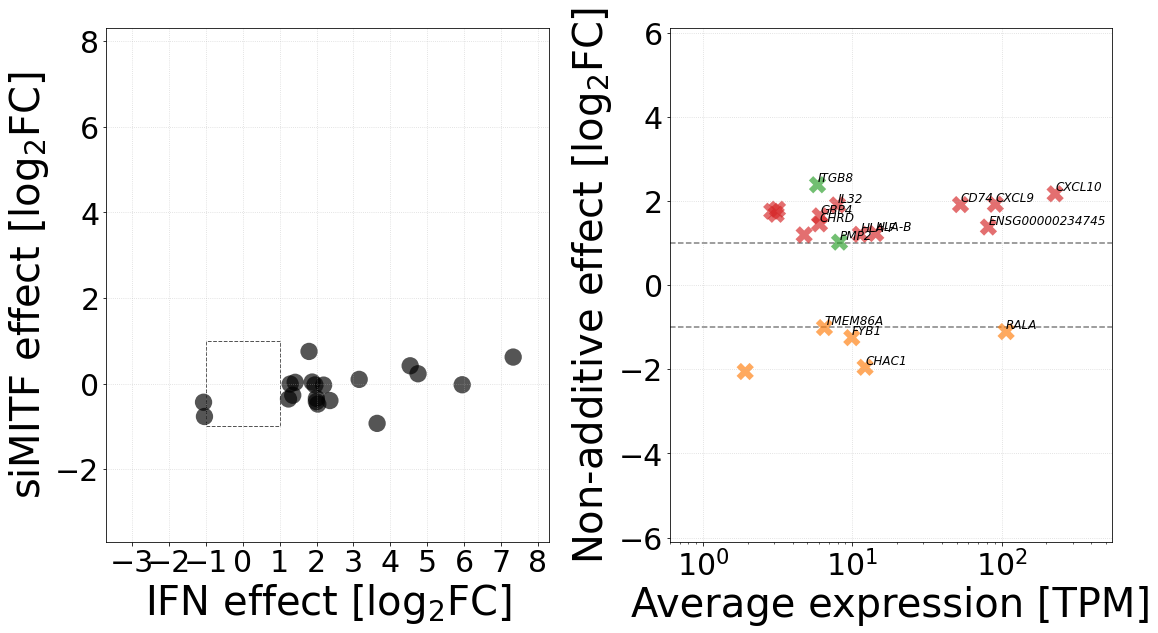

In [28]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9))

x = plotting_setA['A1A0_log2fc'].values
y = plotting_setA['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setA['average_expression_tpm'].values
y = plotting_setA['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

#
# left panel
#
for ensembl, row in plotting_setA.iterrows():
    x = plotting_setA.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setA.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) > 1 and numpy.abs(y) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setA.loc[ensembl, 'average_expression_tpm']
        y = plotting_setA.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setA.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setA.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            the_label = plotting_setA.loc[ensembl, 'geneID']
            right_panel.text(x, y, the_label, horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
left_panel.set_xlim([-3.7, 8.3])
left_panel.set_ylim([-3.7, 8.3])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xlim([0.6, 550])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')
    
matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

# CD74 https://pubmed.ncbi.nlm.nih.gov/31069878/

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 488.6275888051749
-4.345253020438813 5.867488277016092
number of genes in the figure: 23


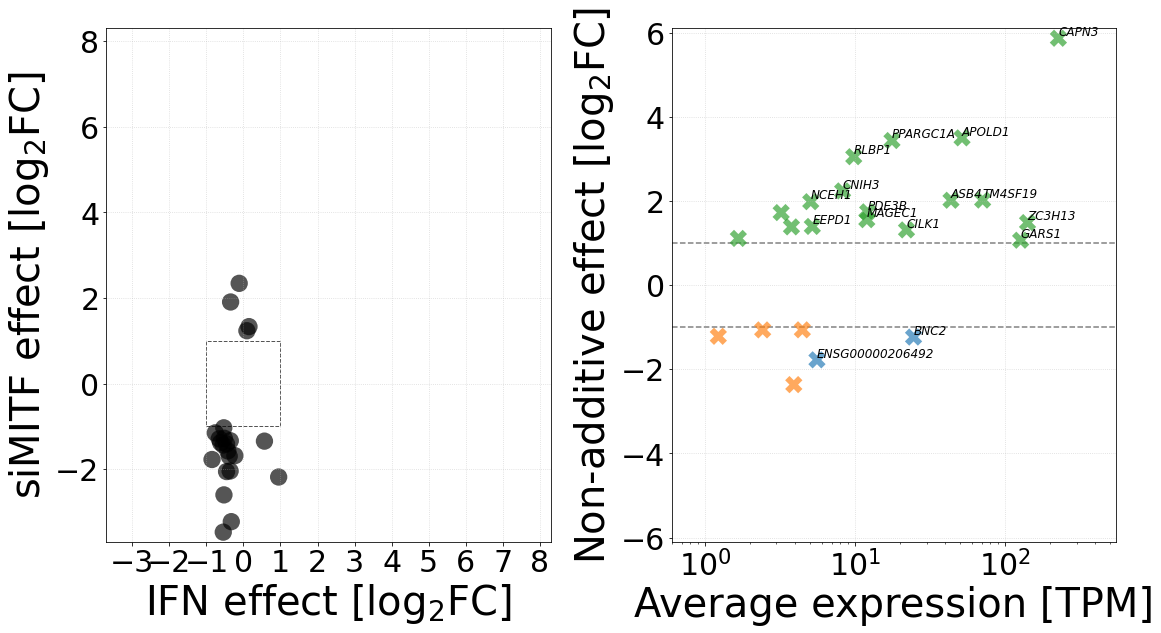

In [29]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9))

x = plotting_setA['A1A0_log2fc'].values
y = plotting_setA['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setA['average_expression_tpm'].values
y = plotting_setA['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

#
# left panel
#
for ensembl, row in plotting_setA.iterrows():
    x = plotting_setA.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setA.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(y) > 1 and numpy.abs(x) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setA.loc[ensembl, 'average_expression_tpm']
        y = plotting_setA.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setA.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setA.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            the_label = plotting_setA.loc[ensembl, 'geneID']
            right_panel.text(x, y, the_label, horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
left_panel.set_xlim([-3.7, 8.3])
left_panel.set_ylim([-3.7, 8.3])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xlim([0.6, 550])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')
    
matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 488.6275888051749
-4.345253020438813 5.867488277016092
number of genes in the figure: 8


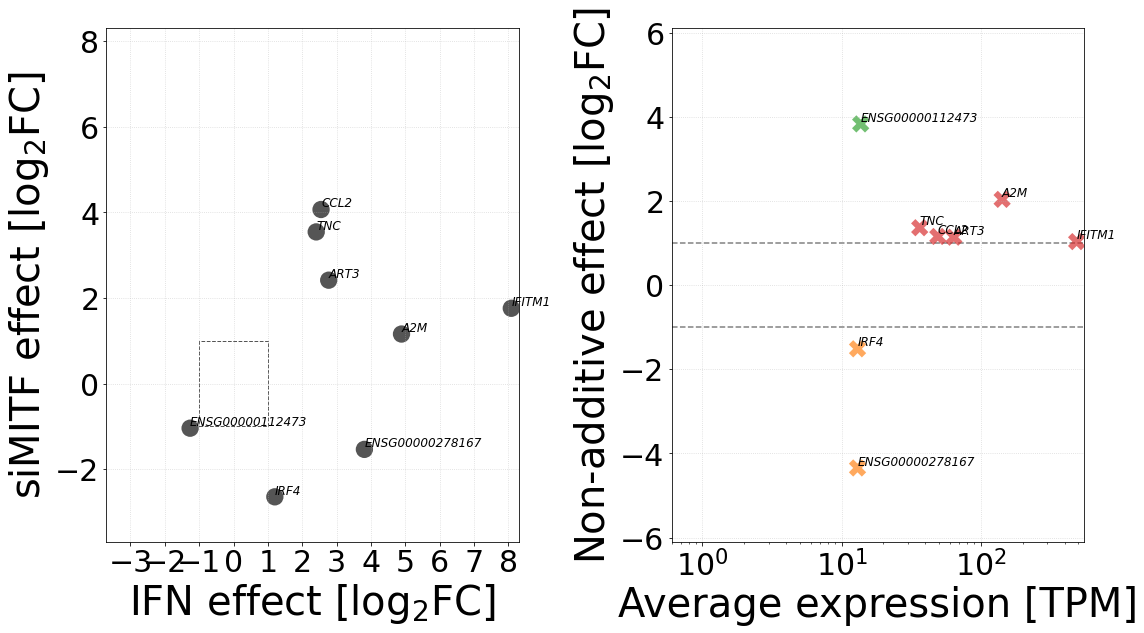

In [36]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9))

x = plotting_setA['A1A0_log2fc'].values
y = plotting_setA['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setA['average_expression_tpm'].values
y = plotting_setA['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

#
# left panel
#
for ensembl, row in plotting_setA.iterrows():
    x = plotting_setA.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setA.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(y) > 1 and numpy.abs(x) > 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        # set the labels
        left_panel.text(x, y, plotting_setA.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        ### right panel
        x = plotting_setA.loc[ensembl, 'average_expression_tpm']
        y = plotting_setA.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setA.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setA.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setA.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setA.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
left_panel.set_xlim([-3.7, 8.3])
left_panel.set_ylim([-3.7, 8.3])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xlim([0.6, 550])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')
    
matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

## 10.2. set B

-1.342040789654414 8.084180132075929
-4.791611531268162 4.0683585030904075
0.6539347368617675 4742.1390047418945
-4.345253020438813 5.867488277016092
number of genes in the figure: 48


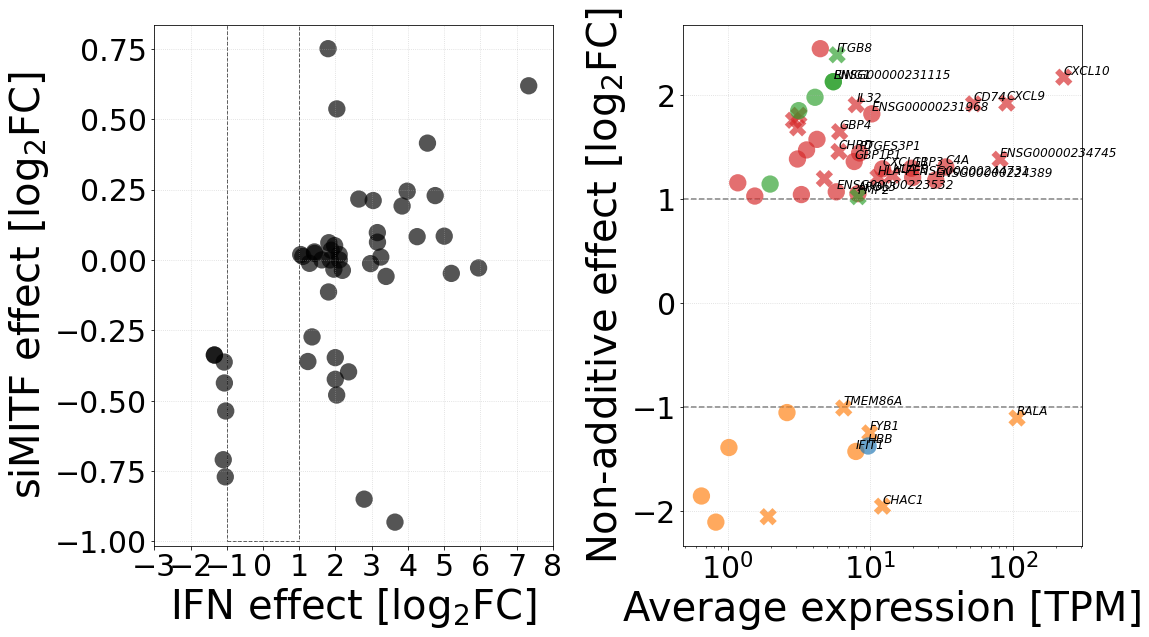

In [40]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9))

x = plotting_setB['A1A0_log2fc'].values
y = plotting_setB['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setB['average_expression_tpm'].values
y = plotting_setB['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setB.iterrows():
    x = plotting_setB.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setB.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) > 1 and numpy.abs(y) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
    
        
        ### right panel
        x = plotting_setB.loc[ensembl, 'average_expression_tpm']
        y = plotting_setB.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setB.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setB.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setB.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setB.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setB.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setB.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
#left_panel.set_xlim([-3.7, 8.3])
#left_panel.set_ylim([-3.7, 8.3])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')

# close right panel
right_panel.set_xscale("log")
#right_panel.set_xlim([0.6, 550])
#right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-1, ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')
    
matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

## 10.3. set C

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092
number of genes in the figure: 152


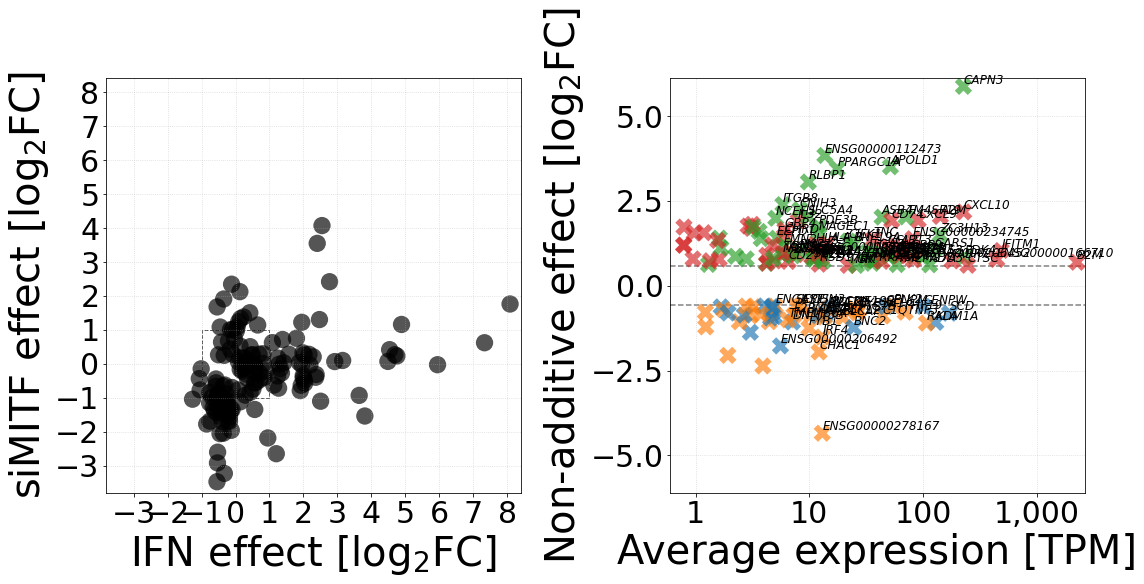

In [92]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setC.iterrows():
    x = plotting_setC.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setC.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) >= 0 and numpy.abs(y) >= 0:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setC.loc[ensembl, 'average_expression_tpm']
        y = plotting_setC.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setC.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setC.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setC.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
        
        
# close left panel
left_panel.set_xlim([-3.8, 8.4])
left_panel.set_ylim([-3.8, 8.4])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')
left_panel.set_aspect('equal', 'box')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
right_panel.set_xlim([0.6, 2650])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')   

matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092
KDM1A	129.69295998868978	-1.0808777383954862	-S
BTN3A1	12.847419229008638	0.810845106911493	+S
RNF19A	24.491263099130624	1.2165393161850915	-A
DNMT3B	7.11518276011609	-1.0706021673784623	-S
SCD	171.247738208404	-0.8140025479426036	-S
CENPM	47.2812715563811	-0.6165251672655749	-S
SLC5A4	9.82102171141165	2.0136762685996397	-A
TMEM87A	59.24032643123253	0.6195114449025905	-A
EYA1	13.83718084863875	-0.8596670760816352	-S
CTSC	248.72431147233448	0.5990430019976971	+S
CNTRL	12.034881254722485	-0.8817122012312035	-S
MCF2L	14.854646403423423	-0.685360375644648	-S
HSD17B7	12.233564194976967	0.6301641942266754	+S
ITGA7	33.41357838888877	1.0230998001366305	-A
EVA1B	14.80195711286265	-0.6764690079582971	+A
SYT14	11.017187463867772	0.7704762971509473	-A
ADD3	114.67782344813567	0.6137574238646097	-A
TNIK	21.994365929068326	0.5953549033440071	+S
FMN2	5

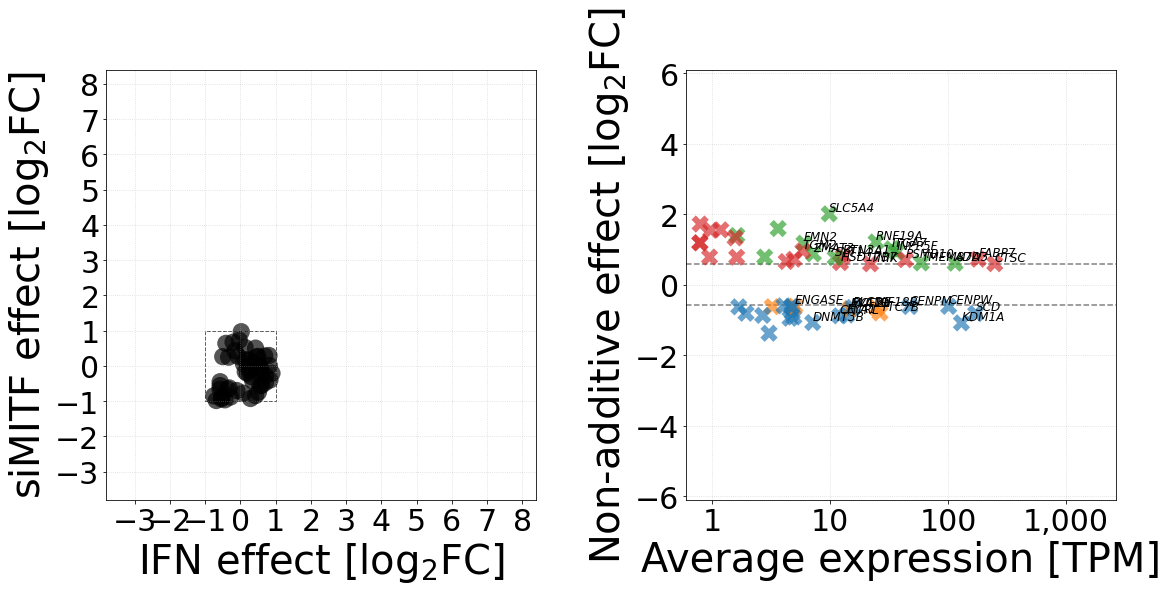

In [95]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setC.iterrows():
    x = plotting_setC.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setC.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) < 1 and numpy.abs(y) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setC.loc[ensembl, 'average_expression_tpm']
        y = plotting_setC.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setC.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setC.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setC.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
            print('{}\t{}\t{}\t{}'.format(plotting_setC.loc[ensembl, 'geneID'],x, y, plotting_setC.loc[ensembl, 'interaction_type']))
        
        
# close left panel
left_panel.set_xlim([-3.8, 8.4])
left_panel.set_ylim([-3.8, 8.4])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')
left_panel.set_aspect('equal', 'box')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
right_panel.set_xlim([0.6, 2650])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')   

matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092
SEMA3F	7.656772649628598	0.9156914813767081	+S
PDK4	231.71918475206525	0.8503919080767828	-A
RALA	107.36400245768374	-1.1044868352040034	+A
IL32	7.979681376326667	1.9061900853990927	+S
CD74	53.14318017568734	1.9142343190610802	+S
FYB1	9.94413754848803	-1.2480371026743287	+A
CHRD	6.041453080422484	1.4559660565051886	+S
ITGB8	5.861488695338888	2.386118243054127	-A
FGF12	11.371068053679823	0.860227093203429	+S
WIPF1	10.436595839394341	-0.8407233367748841	+A
CD274	6.5442194273888346	0.71187092496407	+S
IRF1	63.07263784004812	0.9073484541104371	+S
CHAC1	12.20317215056277	-1.952367164068264	+A
XAF1	10.510759569895537	0.8509041187315396	+S
CXCL9	90.94186753769853	1.9222298536846925	+S
MAP3K12	13.580935170710482	-0.9246602994257489	+A
CYP1A1	27.176598021388003	-0.7212155335787651	+A
PMP2	8.226938603473226	1.0224872545186536	-A
TMEM86A	6.5210331

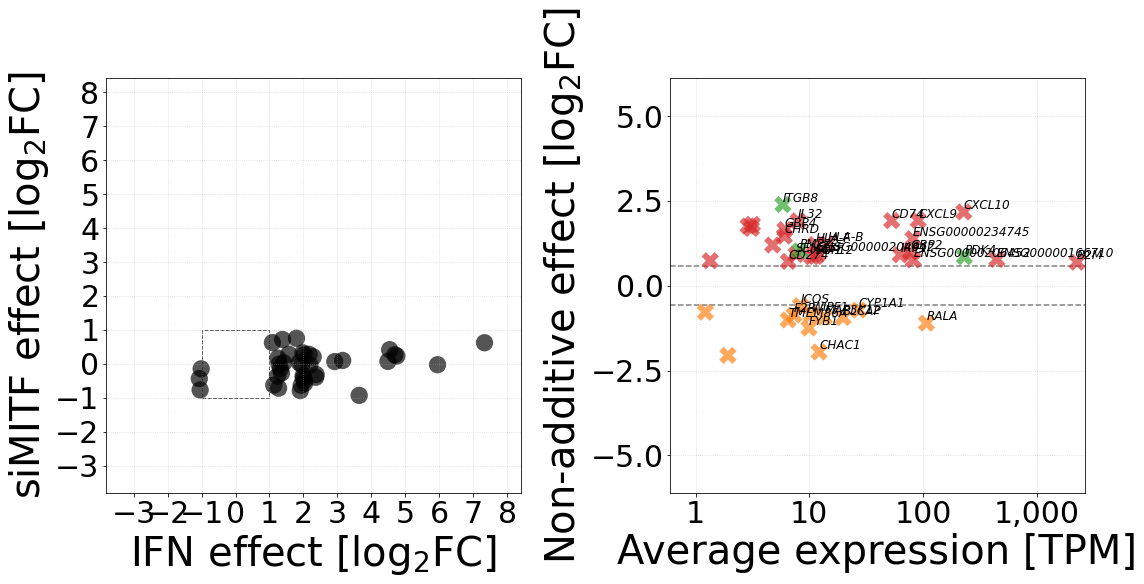

In [96]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setC.iterrows():
    x = plotting_setC.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setC.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) > 1 and numpy.abs(y) < 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setC.loc[ensembl, 'average_expression_tpm']
        y = plotting_setC.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setC.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setC.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setC.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
            print('{}\t{}\t{}\t{}'.format(plotting_setC.loc[ensembl, 'geneID'],x, y, plotting_setC.loc[ensembl, 'interaction_type']))
        
        
# close left panel
left_panel.set_xlim([-3.8, 8.4])
left_panel.set_ylim([-3.8, 8.4])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')
left_panel.set_aspect('equal', 'box')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
right_panel.set_xlim([0.6, 2650])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')   

matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092
ASB4	43.69361629367494	2.0174442573702063	-A
ROPN1	10.714855392426193	0.8482019341277276	-A
GPR137B	52.159570278018776	0.9108820160957602	-A
C1QTNF3	44.298110464011025	-0.8967248528569387	+A
CAPN3	227.12360255465464	5.867488277016092	-A
SEPTIN3	7.616655008060515	-0.5916208501948574	+A
BNIP3L	31.786793988136598	0.7485605575563588	-A
GARS1	127.23535834870411	1.0675602160747326	-A
PPARGC1A	17.652985661550677	3.4368317422917025	-A
CILK1	22.06922802927265	1.3127187651900463	-A
PHF19	69.75362523571883	-0.7838709605916492	+A
EEPD1	5.199678870183366	1.3954610931263562	-A
ZC3H13	141.46968140077223	1.4872547179143139	-A
SWAP70	42.630848917970695	0.8923199699147872	-A
RLBP1	9.820828143333543	3.052494742515237	-A
PRKACB	35.75896099673238	0.6565955120940972	-A
CERS2	100.38787316455239	0.8586180220988462	-A
CNIH3	8.279094140013415	2.239935655810776	-

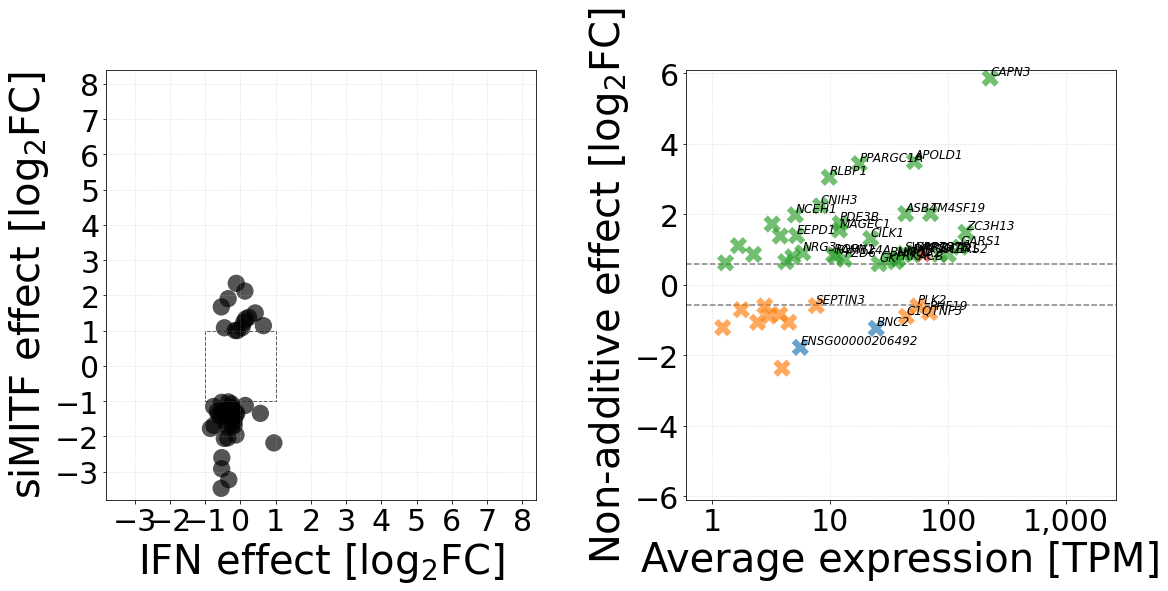

In [97]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setC.iterrows():
    x = plotting_setC.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setC.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) < 1 and numpy.abs(y) > 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setC.loc[ensembl, 'average_expression_tpm']
        y = plotting_setC.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setC.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setC.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setC.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
            print('{}\t{}\t{}\t{}'.format(plotting_setC.loc[ensembl, 'geneID'],x, y, plotting_setC.loc[ensembl, 'interaction_type']))
        
        
# close left panel
left_panel.set_xlim([-3.8, 8.4])
left_panel.set_ylim([-3.8, 8.4])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')
left_panel.set_aspect('equal', 'box')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
right_panel.set_xlim([0.6, 2650])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')   

matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092
TNC	36.42416982563604	1.3648608371054012	+S
TNFSF13B	35.84433770557371	0.7561658323700975	+S
CCL2	49.121468486172944	1.1570737959160349	+S
ENSG00000112473	13.716428697576651	3.8319471217171497	-A
IRF4	13.02346896740473	-1.5133549816404304	+A
ART3	64.07231066485375	1.1393201116716973	+S
ACOX2	6.639142594924881	0.9514515963664847	+S
A2M	142.39714320193664	2.0383727040221595	+S
IFITM1	488.6275888051749	1.0345983926805093	+S
ENSG00000278167	13.01935262521838	-4.345253020438813	+A
number of genes in the figure: 11


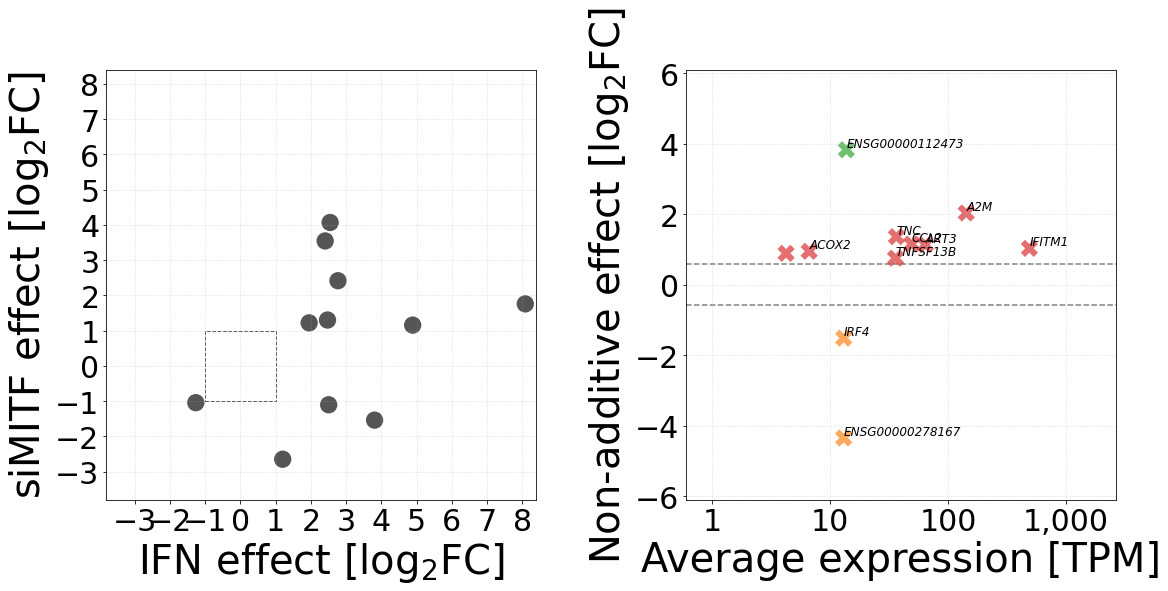

In [98]:
fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))

counter = 0

for ensembl, row in plotting_setC.iterrows():
    x = plotting_setC.loc[ensembl, 'A1A0_log2fc']
    y = plotting_setC.loc[ensembl, 'B0A0_log2fc']
    if numpy.abs(x) > 1 and numpy.abs(y) > 1:
        
        counter = counter + 1
        
        ### left panel
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        
        ### right panel
        x = plotting_setC.loc[ensembl, 'average_expression_tpm']
        y = plotting_setC.loc[ensembl, 'log2FC_observed_expected']
    
        # set the color
        if plotting_setC.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif plotting_setC.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # set the marker
        if plotting_setC.loc[ensembl, 'P_interaction'] < 0.05:
            the_marker = 'X'
        else:
            the_marker = 'o'

        right_panel.scatter(x, y, s=300, marker=the_marker, c=the_color, alpha=2/3, edgecolor='none')
        
        # set the labels
        if x > 5:
            right_panel.text(x, y, plotting_setC.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=12, fontstyle='italic')
            print('{}\t{}\t{}\t{}'.format(plotting_setC.loc[ensembl, 'geneID'],x, y, plotting_setC.loc[ensembl, 'interaction_type']))
        
        
# close left panel
left_panel.set_xlim([-3.8, 8.4])
left_panel.set_ylim([-3.8, 8.4])
left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
left_panel.set_xlabel('IFN effect [log$_2$FC]')
left_panel.set_ylabel('siMITF effect [log$_2$FC]')
the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
left_panel.add_patch(the_patch)
left_panel.grid(alpha=0.5, ls=':')
left_panel.set_aspect('equal', 'box')

# close right panel
right_panel.set_xscale("log")
right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
right_panel.set_xlim([0.6, 2650])
right_panel.set_ylim([-6.1, 6.1])
right_panel.set_xlabel('Average expression [TPM]')
right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
right_panel.grid(alpha=0.5, ls=':')   

matplotlib.pyplot.tight_layout()

print('number of genes in the figure: {}'.format(counter))